# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd

from astropy.stats import sigma_clipped_stats
from photutils import datasets
from photutils.detection import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture, ApertureStats, CircularAnnulus, aperture_photometry
from photutils.psf import fit_fwhm
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time
import astropy.units as u

# Bias and Noise

In [3]:
image_files = ["M11_2025_SEP_18/CCD Image " + str(n) + ".fit" for n in range(76, 86)]

In [4]:
image_concat = np.array([fits.getdata(f) for f in image_files])

In [5]:
def get_master_bias(file_list):
    bias_frames = []
    for img in file_list:
        bias_frames.append(img)

    master_bias = np.median(np.stack(bias_frames, axis=0), axis=0)

    return master_bias

In [6]:
master_bias = get_master_bias(image_concat)

In [7]:
print(master_bias.shape)

(512, 2048)


# Flats

In [8]:
def get_flats(types):
    if types == "Blue":
        r = range(60, 65)
    elif types == "Green":
        r = range(71, 76)
    elif types == "Orange":
        r = range(66, 71)
    l = ["M11_2025_SEP_18/CCD Image " + str(n) + ".fit" for n in r]
    flats = []
    for file in l:
        img = fits.getdata(file)
        flats.append(img / np.median(img))

    master_flat = np.median(np.stack(flats, axis=0), axis=0)

    return master_flat

In [10]:
get_flats("Orange")[250:350, 650:950]

array([[0.84787736, 0.78436019, 0.77014218, ..., 0.84241706, 0.75117925,
        0.75592417],
       [0.84787736, 0.78327444, 0.77004717, ..., 0.83510012, 0.75235849,
        0.75029446],
       [0.85041225, 0.77830189, 0.76658768, ..., 0.84687868, 0.75353774,
        0.75825472],
       ...,
       [0.86219081, 0.79363208, 0.73933649, ..., 0.66981132, 0.69266589,
        0.73498233],
       [0.85630153, 0.79620853, 0.7322468 , ..., 0.67020024, 0.68433451,
        0.73696682],
       [0.86808009, 0.79146919, 0.74174528, ..., 0.66943128, 0.68551237,
        0.72991851]], shape=(100, 300))

# Science Source

In [883]:
fits.open("M11_2025_SEP_18/CCD Image 51.fit")[0].header
#plt.imshow(data_ex, cmap='gray')
#plt.savefig("calibblue")

SIMPLE  =                    T                                                  
BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 2048 /fastest changing axis                           
NAXIS2  =                  512 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           
BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           
DATE-OBS= '2025-09-19T01:11:25' /YYYY-MM-DDThh:mm:ss observation start, UT      
EXPTIME =  0.29999999999999999 /Exposure time in seconds                        
EXPOSURE=  0.29999999999999999 /Exposure time in seconds                        
SET-TEMP=  -50.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=  3.363757548557E-038 /CCD temperature at start of exposure in C       
XPIXSZ  =   13.5000000000000

In [1169]:
def get_airmass(hdr):

    # Use correct Cornell coordinates (lat, lon in degrees, height ~ 240 m)
    site = EarthLocation(lat=42.45840254047993*u.deg,
                         lon=-76.38455829550382*u.deg)  # Cornell elevation ~240 m
    
    # Extract observation time
    obs_time = Time(hdr['DATE-OBS'])
    
    # === Example: M11 coordinates from your table ===
    target = SkyCoord("18h51m05s -06d16m12s")
    
    # Convert to Alt/Az
    altaz = target.transform_to(AltAz(obstime=obs_time, location=site))
    
    # Compute airmass
    airmass = altaz.secz  # sec(z) where z = zenith distance
    print(f"Altitude: {altaz.alt:.2f}")
    print(f"Airmass: {airmass:.3f}")


In [1173]:
get_airmass(fits.getheader("M11_2025_SEP_18/CCD Image 14.fit"))
get_airmass(fits.getheader("M11_2025_SEP_18/CCD Image 24.fit"))
get_airmass(fits.getheader("M11_2025_SEP_18/CCD Image 32.fit"))

Altitude: 40.60 deg
Airmass: 1.537
Altitude: 40.39 deg
Airmass: 1.543
Altitude: 40.17 deg
Airmass: 1.550


In [49]:
def print_stats(sources):
    for col in sources.colnames:
        sources[col].info.format = '%.8g'  # for consistent table output
    sources.pprint(max_lines=-1, max_width=-1)

In [1133]:
def get_data_points(types):
    '''
    begin: begin number in folder
    end: end number in folder
    types: type of the measurements (ex. Science Orange corresponds to science source with orange filter)
    '''

    config = {
        "Science Orange": (range(14, 19), "Orange"),
        "Science Green":  (range(20, 25), "Green"),
        "Science Blue":   (range(28, 33), "Blue"),
        "Calibration Orange": ([39, 42, 43, 44, 45], "Orange"),
        "Calibration Green":  (range(47, 52), "Green"),
        "Calibration Blue":   (range(54, 59), "Blue"),
    }
    r, filt = config[types]
    flats = get_flats(filt)

    l = ["M11_2025_SEP_18/CCD Image " + str(n) + ".fit" for n in r]
    hdus = []
    for image_file in l:
        img = fits.getdata(image_file)
        hdus.append((img - master_bias) / flats)
    data = np.median(hdus, axis=0)


    plt.imshow(data, cmap='gray')
    mean, median, std = sigma_clipped_stats(data, sigma=5.0)
    print(types + " mean: " + str(mean) + " median: " + str(median) + " std: " + str(std))
    # load the DAOStarFinder function. The FWHM tell it how to determine the radius of a star
    # the threshold helps determine when to ignore something and consider it not a star.

    # Give a high threshold, only brighter stars will be selected, a low threshold will circle nearly everything
    if "Calibration" in types:
        threshold = 16. * std
    else:
        threshold = 5 * std

    # this tells which size of PSF (size of star on image) that you want to circle. Give a high fwhm to circle larger PSF's
    # or in other words, larger stars. Give a small fwhm to circle smaller PSF's or 'smaller' stars.
    fwhm = 3
    daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold)

    # subtract the background from the imgage so the software doesn't get background light confused with stars
    background_subracted_data = data - median

    mask = None
    if "Calibration" in types:
        mask = np.zeros(data.shape, dtype=bool)
        mask[0:100, 800:1000] = True          # first excluded box
        mask[250:351, 150:351] = True         # second excluded box
    else:
        mask = np.zeros(data.shape, dtype=bool)
        mask[280:300, 900:950] = True          # first excluded box

    sources = daofind(background_subracted_data, mask=mask)
    xypos = list(zip(sources['xcentroid'], sources['ycentroid']))
    fwhm = fit_fwhm(background_subracted_data, xypos=xypos, fit_shape=(5, 5))
    print(f"Stars detected: {len(sources)}")
    print(f"fwhm: {np.median(fwhm)}")

    # You will then get a bunch of information about the stars you find which you can print out
    #print_stats(sources_nomask)
    circle_size = 5
    # So this just transposes the positions matrix so the data is in the right format for photutil
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    # This is a photutil function which draws circles around targets
    apertures = CircularAperture(positions, r=circle_size)
    annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)
    aperstats = ApertureStats(data, annulus_aperture)
    bkg_mean = aperstats.mean
    apstats = ApertureStats(data, apertures)
    aperture_area = apertures.area_overlap(data)
    total_bkg = bkg_mean * aperture_area
    phot_table = aperture_photometry(data, apertures)
    phot_bkgsub = phot_table['aperture_sum'] - total_bkg
    phot_table['total_bkg'] = total_bkg
    phot_table['aperture_sum_bkgsub'] = phot_bkgsub

    # normalized the image by the sqrt so more details can be seen
    norm = ImageNormalize(stretch=SqrtStretch())

    # this sets the plot size to 12 by 12
    plt.figure(figsize=(12, 12))

    # plot the data using imshow, use a colormap that is gray
    plt.imshow(data, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
    apertures.plot(color='blue', lw=1.5, alpha=0.5)
    plt.savefig("examplegreenwithsources")
    plt.show()

    return phot_table, median, apertures, apstats, positions, annulus_aperture

In [740]:
def sky_brightness(median, exposure_time, zp):
    sky_per_sec = median / exposure_time
    area_pix = (0.325)**2  
    return zp - 2.5 * np.log10(sky_per_sec / area_pix)

### Green

Science Green mean: 4.770936551211129 median: 4.648101265822785 std: 1.411870667638384
Stars detected: 236
fwhm: 7.364839961175916


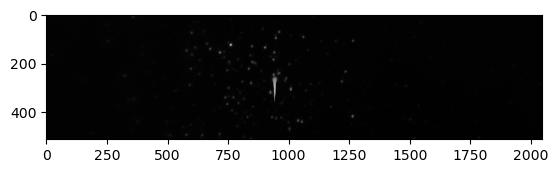

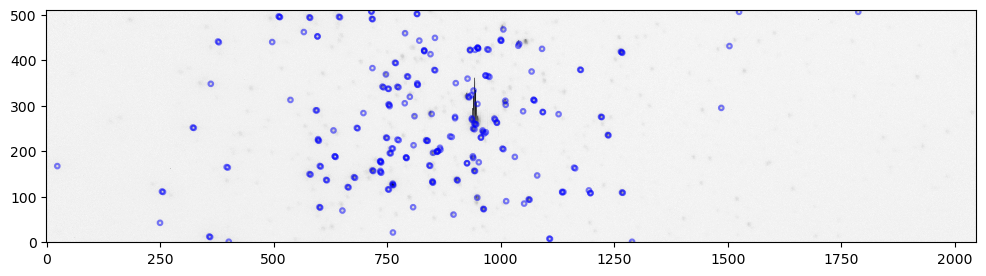

In [1135]:
greens, _, aps, _, pos, aa = get_data_points("Science Green")

In [1155]:
print(sky_brightness(4.648101265822785, 10, green_zp))
print(sky_brightness(2.9581881533101044, 3, orange_zp))
print(sky_brightness(2.4736842105263155, 10, blue_zp))

11.630083362074071
10.436482522476648
11.35527640111616


Science Orange mean: 3.1620781373889946 median: 2.9581881533101044 std: 1.2495462648557927


Stars detected: 202
fwhm: 5.659222076486716


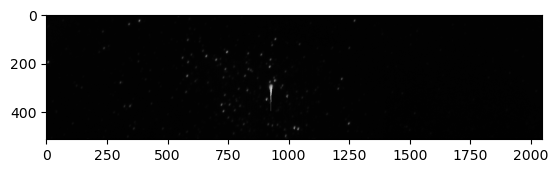

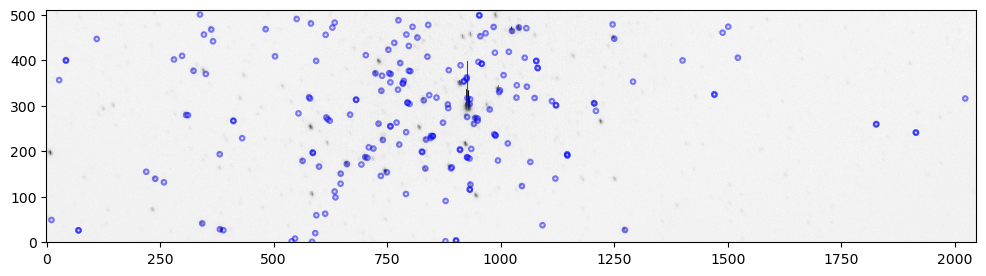

In [1137]:
_ = get_data_points("Science Orange")

Science Blue mean: 2.5643109297532325 median: 2.4736842105263155 std: 1.0117377795802767
Stars detected: 118
fwhm: 6.159943879146963


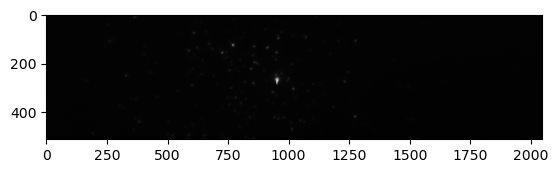

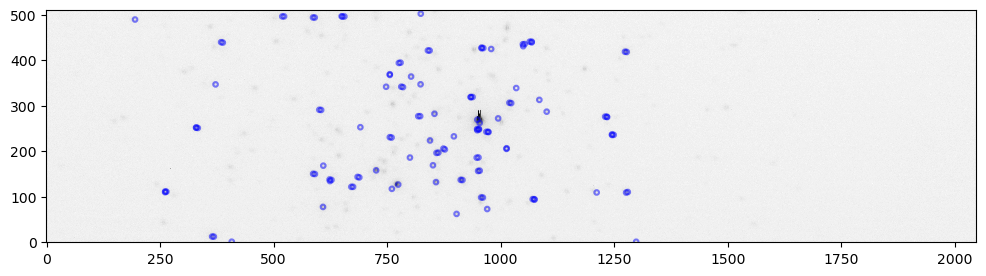

In [1139]:
_ = get_data_points("Science Blue")

In [889]:
def get_data(types):
    config = {
        "Science Orange": (range(14, 19), "Orange"),
        "Science Green":  (range(20, 25), "Green"),
        "Science Blue":   (range(28, 33), "Blue"),
        "Calibration Orange": ([39, 42, 43, 44, 45], "Orange"),
        "Calibration Green":  (range(47, 52), "Green"),
        "Calibration Blue":   (range(54, 59), "Blue"),
    }
    r, filt = config[types]
    flats = get_flats(filt)

    l = ["M11_2025_SEP_18/CCD Image " + str(n) + ".fit" for n in r]
    hdus = []
    for image_file in l:
        img = fits.getdata(image_file)
        hdus.append((img - master_bias) / flats)
    data = np.median(hdus, axis=0)
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)

    return data

In [1003]:
def get_phot_table(data, shifted):
    shifted_a = CircularAperture(shifted, r = 5)
    shifted_aa = CircularAnnulus(shifted, r_in = 10, r_out = 15)
    aperstats = ApertureStats(data, shifted_aa)
    bkg_mean = aperstats.mean
    aperture_area = shifted_a.area_overlap(data)
    total_bkg = bkg_mean * aperture_area
    phot_table = aperture_photometry(data, shifted_a)
    phot_bkgsub = phot_table['aperture_sum'] - total_bkg
    phot_table['total_bkg'] = total_bkg
    phot_table['aperture_sum_bkgsub'] = phot_bkgsub
    return phot_table

In [1005]:
orange_img = get_data("Science Orange")
#orange_sources = aperture_photometry(orange_img, aps)

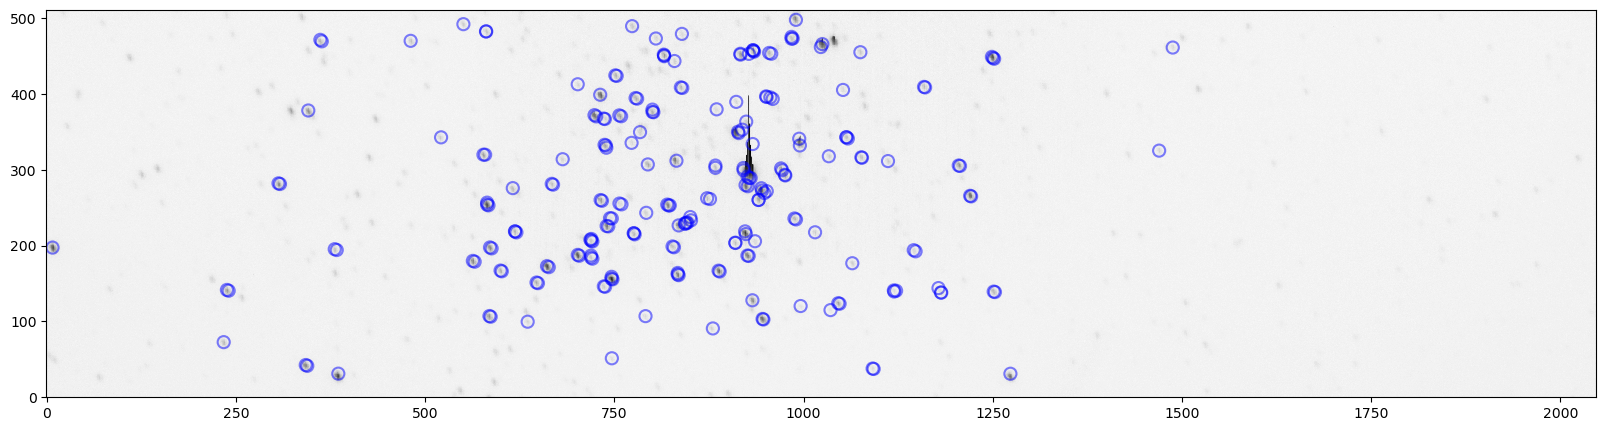

In [1007]:
# Suppose you found blue is shifted slightly right (+dx) and maybe up/down (+dy)
dx_o = -16   # pixels to the right
dy_o = 30  # pixels upward (negative y if image origin is lower-left)

shifted_positions_o = [(x + dx_o, y + dy_o) for x, y in pos]

shifted_apertures_o = CircularAperture(shifted_positions_o, r=8)
shifted_annulus_apertures_o = CircularAnnulus(shifted_positions_o, r_in=10, r_out=15)


plt.figure(figsize=(20, 20))
plt.imshow(orange_img, cmap='Greys', origin='lower', norm=ImageNormalize(stretch=SqrtStretch()), interpolation='nearest')
shifted_apertures_o.plot(color='blue', lw=1.5, alpha=0.5)
plt.show()

orange_sources = get_phot_table(orange_img, shifted_positions_o)

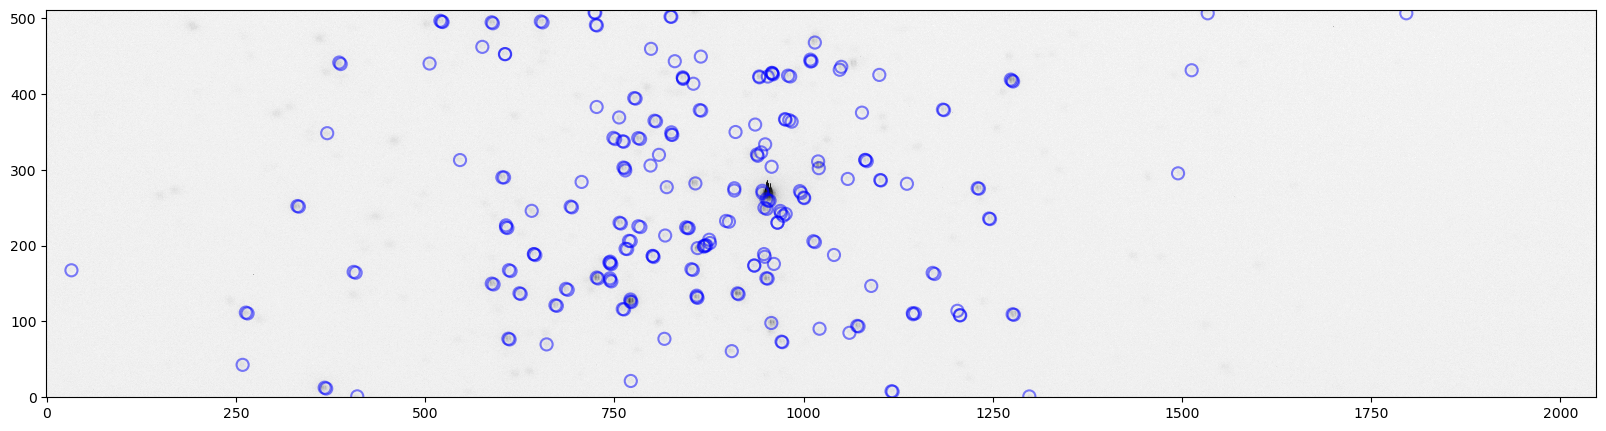

In [1009]:
# Suppose you found blue is shifted slightly right (+dx) and maybe up/down (+dy)
dx = 9   # pixels to the right
dy = 0  # pixels upward (negative y if image origin is lower-left)

shifted_positions = [(x + dx, y + dy) for x, y in pos]

shifted_apertures = CircularAperture(shifted_positions, r=8)
plt.figure(figsize=(20, 20))
plt.imshow(blue_img, cmap='Greys', origin='lower', norm=ImageNormalize(stretch=SqrtStretch()), interpolation='nearest')
shifted_apertures.plot(color='blue', lw=1.5, alpha=0.5)
plt.show()

In [1011]:
blue_img = get_data("Science Blue")
blue_sources = get_phot_table(blue_img, shifted_positions)

In [1015]:
green_img = get_data("Science Green")
green_sources = get_phot_table(green_img, pos)

# Calibration Star

Calibration Orange mean: 1.8125762161007122 median: 1.8356756756756758 std: 0.8086119689340323
Stars detected: 2
fwhm: 6.1643258319742396


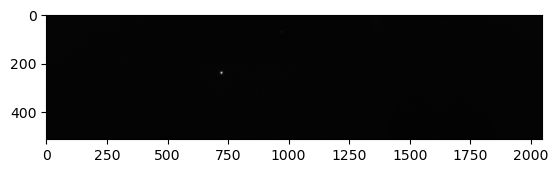

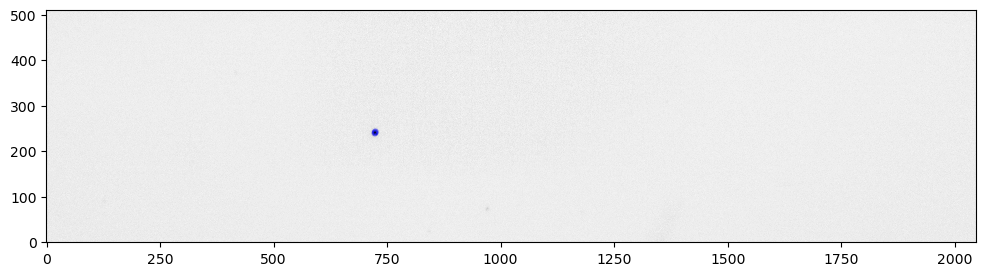

In [1141]:
orange_calibration, orange_cali_median, _, orange_apertures, _, _ = get_data_points("Calibration Orange")

In [1034]:
print_stats(orange_calibration)

 id  xcenter   ycenter  aperture_sum total_bkg aperture_sum_bkgsub
--- --------- --------- ------------ --------- -------------------
  1 723.13316 239.90497    8057.3411  353.3237           7704.0174
  2  723.9693 242.69154    6807.2326 372.17212           6435.0605


In [1149]:
orange_pz = 7.321 + 2.5 * np.log10(orange_calibration['aperture_sum_bkgsub'] / 0.1)[0]

In [1151]:
print(orange_pz)

19.53779313175872


In [1041]:
orange_apertures[0].fwhm

<Quantity 5.13838009 pix>

In [1085]:
print(sky_brightness(orange_cali_median, 0.1, orange_pz))

11.437720053730837


Calibration Green mean: 1.8307815223245973 median: 1.8888888888888888 std: 0.7914402346235843
Stars detected: 2
fwhm: 5.933901959339434


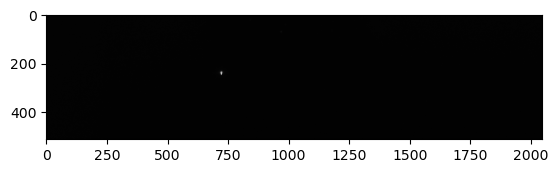

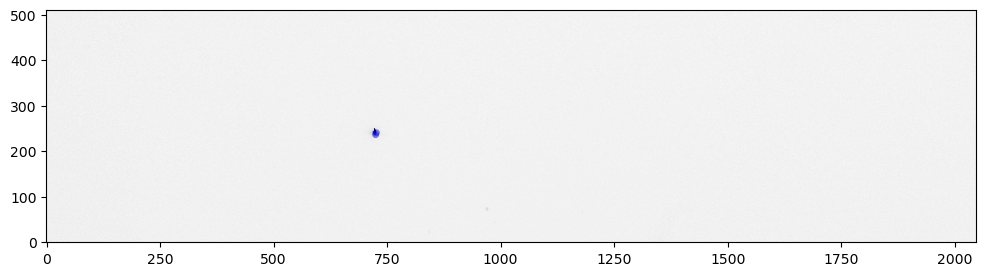

In [1143]:
green_calibration, green_cali_median, _, green_apertures, _, _ = get_data_points("Calibration Green")

In [1087]:
green_pz = 7.395 + 2.5 * np.log10(green_calibration['aperture_sum_bkgsub'][0] / 0.3)

In [1089]:
print(green_pz)

18.573697463735797


In [1131]:
print(green_apertures[0].fwhm)

5.012530594294717 pix


In [1091]:
print(sky_brightness(green_cali_median, 0.1, green_pz))

12.942598238782796


Calibration Blue mean: 1.663611555290639 median: 1.8989898989898992 std: 0.7360927418890095
Stars detected: 1
fwhm: 5.111059835646065


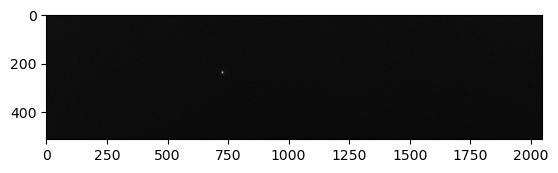

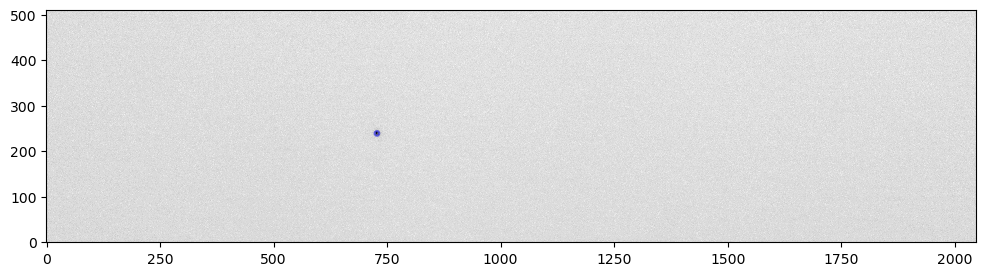

In [1145]:
blue_calibration, blue_cali_median, _, blue_apertures, _, _ = get_data_points("Calibration Blue")

In [1093]:
blue_pz = 7.502 + 2.5 * np.log10(blue_calibration['aperture_sum_bkgsub'][0] / 0.1)
print(blue_pz)

18.096999862980912


In [1095]:
print(blue_apertures.fwhm)

[5.04270859] pix


In [1097]:
print(sky_brightness(blue_cali_median, 0.1, blue_pz))

12.46011003120996


# Colors

In [1175]:
B = blue_pz-2.5*np.log10(blue_sources['aperture_sum_bkgsub']/10) 
V = green_pz-2.5*np.log10(green_sources['aperture_sum_bkgsub']/10)
color = B - V

/var/folders/kh/46fkh84d3699xzz7ybmcqqp00000gn/T/ipykernel_91628/2000353431.py:1: RuntimeWarning: invalid value encountered in log10
  B = blue_pz-2.5*np.log10(blue_sources['aperture_sum_bkgsub']/10)
/var/folders/kh/46fkh84d3699xzz7ybmcqqp00000gn/T/ipykernel_91628/2000353431.py:2: RuntimeWarning: invalid value encountered in log10
  V = green_pz-2.5*np.log10(green_sources['aperture_sum_bkgsub']/10)


In [1177]:
#print("Blue: ", b, "Green: ", v, "B-V:", b-v)

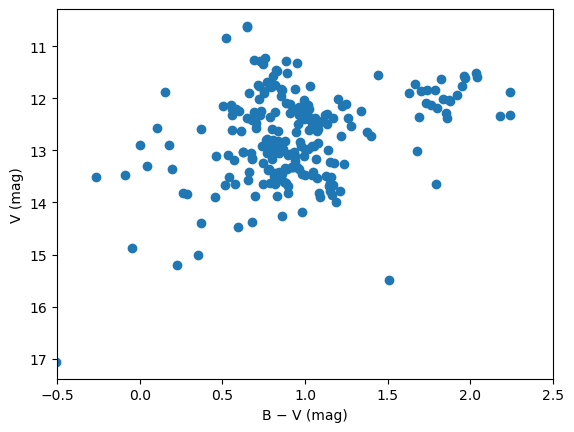

In [1183]:
plt.scatter(color, V, marker='o')
plt.xlabel("B − V (mag)")
plt.ylabel("V (mag)")
plt.xlim(-0.5, 2.5)
plt.gca().invert_yaxis()  
plt.savefig("CMD")
plt.show()

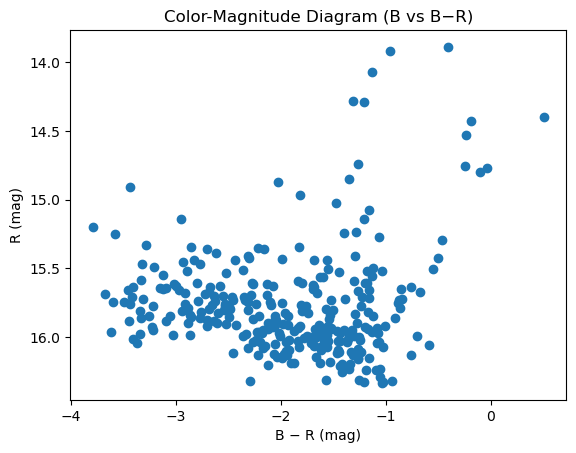

In [2003]:
plt.scatter(v- b, b, marker='o')
plt.xlabel("B − R (mag)")
plt.ylabel("R (mag)")
#plt.xlim(-2, 4)
plt.gca().invert_yaxis()  

plt.title("Color-Magnitude Diagram (B vs B−R)")
plt.show()